In [4]:
import numpy as np 
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


# The goal of that notebook is to build a model able to distinguish between rand writen digits, and corectly predict a digit in range form 0 to 9
We will discouse
1. EDA
2. Modeling
3. Predcitions, results and conclusions
4. Modelin usning Deep Learning techniques and algorytms
5. Predcitions, results and conclusions
6. Summary

In creation of this notebook i used as a helper and inspiration a book by  Aurélien Géron "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems" 


In [5]:
# Tools
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import make_scorer , accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns




# Modles
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier



 # EDA

In [6]:
train_data = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
train_data

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Below plot shows that we have balanced data set

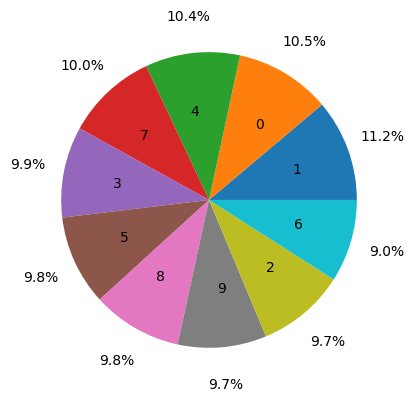

In [7]:
labels_count = (train_data["label"].value_counts()/train_data["label"].count())*100 
unique_labels = train_data["label"].unique() 

fig, ax = plt.subplots()
ax.pie(labels_count, labels=unique_labels, autopct='%1.1f%%',
       pctdistance=1.25, labeldistance=.6)

plt.show()

In [8]:
has_missing_data = np.isnan(train_data.values).any()
if has_missing_data:
    print("There is missing data")
else:
    print("No missing data")

No missing data


# Modeling

Since the dataset is images in pandas DataFrame and DataFrame is not perffect for handling images we should turn it into numpy array

In [9]:
y = train_data["label"].to_numpy()
y.shape

(42000,)

In [10]:
X = train_data.drop("label", axis=1).to_numpy()
X.shape

(42000, 784)

Data scaling is important in that problem since we have large range of values 0-255.
The most common way to scale pixel values is Normalization. We rescale vlaues to be in  the range [0,1]

In [11]:
X = X/255.0 # Normalization


We wont encode target variable, because we will not use Tensorflow but Pytorch where there is no need to encode lables, also sklearn models can handle target variables as numbers

In [12]:
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.2, random_state=42)

5


(None, None)

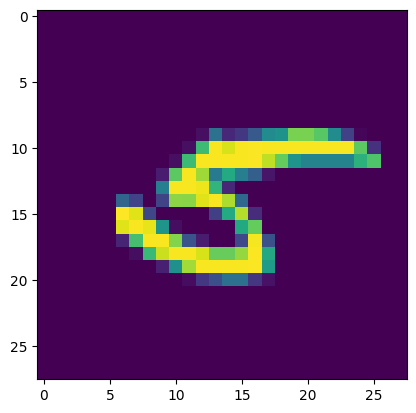

In [13]:
def show_img(img):
    """Function takes image indencies as numpy array and plot it
    img : numpay arrya of pixels values"""
    img = img.reshape(28,28)
    plt.imshow(img)
    
show_img(X_train[22]), print(y_train[22])
    

### Cross-Validation

Since our dataset hav 10 different target variables (numbers from 0 to 9) it is really important to compute precision, recal and f1_socre and then confusion matrix of our models performance. 
Accuracy is not enough. Suppose we measure just accuracy, so when model will just guess, and infrace every time the number is 1, it would be right in 11% of times. In the first  look thats seems like not much, but te problem is real.

In [14]:
models = {
    "LogReg": LogisticRegression(random_state=42, max_iter=1000),
    "RF": RandomForestClassifier(random_state=42),
    "SVC": SVC(random_state=42),
    "KNN":KNeighborsClassifier(),
    "SGD":SGDClassifier()
}

scoring = {
        "accuracy": make_scorer(accuracy_score),
        "f1_macro": make_scorer(f1_score, average='macro'),
        "f1_micro": make_scorer(f1_score, average='micro'),
        "recall": make_scorer(recall_score, average='macro'),
        "precision": make_scorer(precision_score, average='macro', zero_division=0)
    }   
    

def cross_val(X_train,y_train, cv, models,scoring):
    """
    Function to evaluate multiple models using cross-validation on a given dataset.
    
    X_train : array-like
    y_train : array-like
    cv : int
    models : dict
    scoring : dict
    
    Returns:
    models_results : dict
    parameters : dict
    """
    
    parameters = {}
    models_results = {}
    
    cv_S = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    
    for name, model in models.items():
        result = cross_validate(model,X=X_train,y=y_train,cv=cv_S, scoring=scoring,verbose = 0,)
        parameters[name] = model.get_params()
        models_results[name] = {}
        
        for key, value in result.items():
            if key.startswith("test"):
                value_mean = np.mean(value)
                models_results[name][key] = value_mean
    return models_results, parameters

## Note!
Due to the fact that training the model takes a very long time (even with accelerators), I decided to present the results in a pre-existing dictionary

In [15]:
# results_baseline = cross_val(X_train=X_train, y_train=y_train, cv=3, models=models, scoring=scoring)


Models' results and their parameters are stored inside  `results_baseline_dict` 

In [16]:
results_baseline_dict = (
    {'LogReg': {'test_accuracy': 0.9137202380952382,
       'test_f1_macro': 0.9124987780703928,
       'test_f1_micro': 0.9137202380952382,
       'test_recall': 0.9124654663573808,
       'test_precision': 0.9126936146045607},
      'RF': {'test_accuracy': 0.9598809523809524,
       'test_f1_macro': 0.9595575753051785,
       'test_f1_micro': 0.9598809523809524,
       'test_recall': 0.9596124631666738,
       'test_precision': 0.959568160241846},
      'SVC': {'test_accuracy': 0.9713988095238095,
       'test_f1_macro': 0.9711747579609011,
       'test_f1_micro': 0.9713988095238095,
       'test_recall': 0.9712143323172855,
       'test_precision': 0.9711853195765973},
      'KNN': {'test_accuracy': 0.9619047619047619,
       'test_f1_macro': 0.9616159426998636,
       'test_f1_micro': 0.9619047619047619,
       'test_recall': 0.9612106623235767,
       'test_precision': 0.962611491536245},
      'SGD': {'test_accuracy': 0.9044642857142856,
       'test_f1_macro': 0.9030053563893716,
       'test_f1_micro': 0.9044642857142856,
       'test_recall': 0.9030346261021562,
       'test_precision': 0.9043045270440652}},
     {'LogReg': {'C': 1.0,
       'class_weight': None,
       'dual': False,
       'fit_intercept': True,
       'intercept_scaling': 1,
       'l1_ratio': None,
       'max_iter': 1000,
       'multi_class': 'auto',
       'n_jobs': None,
       'penalty': 'l2',
       'random_state': 42,
       'solver': 'lbfgs',
       'tol': 0.0001,
       'verbose': 0,
       'warm_start': False},
      'RF': {'bootstrap': True,
       'ccp_alpha': 0.0,
       'class_weight': None,
       'criterion': 'gini',
       'max_depth': None,
       'max_features': 'sqrt',
       'max_leaf_nodes': None,
       'max_samples': None,
       'min_impurity_decrease': 0.0,
       'min_samples_leaf': 1,
       'min_samples_split': 2,
       'min_weight_fraction_leaf': 0.0,
       'n_estimators': 100,
       'n_jobs': None,
       'oob_score': False,
       'random_state': 42,
       'verbose': 0,
       'warm_start': False},
      'SVC': {'C': 1.0,
       'break_ties': False,
       'cache_size': 200,
       'class_weight': None,
       'coef0': 0.0,
       'decision_function_shape': 'ovr',
       'degree': 3,
       'gamma': 'scale',
       'kernel': 'rbf',
       'max_iter': -1,
       'probability': False,
       'random_state': 42,
       'shrinking': True,
       'tol': 0.001,
       'verbose': False},
      'KNN': {'algorithm': 'auto',
       'leaf_size': 30,
       'metric': 'minkowski',
       'metric_params': None,
       'n_jobs': None,
       'n_neighbors': 5,
       'p': 2,
       'weights': 'uniform'},
      'SGD': {'alpha': 0.0001,
       'average': False,
       'class_weight': None,
       'early_stopping': False,
       'epsilon': 0.1,
       'eta0': 0.0,
       'fit_intercept': True,
       'l1_ratio': 0.15,
       'learning_rate': 'optimal',
       'loss': 'hinge',
       'max_iter': 1000,
       'n_iter_no_change': 5,
       'n_jobs': None,
       'penalty': 'l2',
       'power_t': 0.5,
       'random_state': None,
       'shuffle': True,
       'tol': 0.001,
       'validation_fraction': 0.1,
       'verbose': 0,
       'warm_start': False}})



In [17]:
# Baseline models results
models_table = pd.DataFrame(results_baseline_dict[0])
models_table.style.highlight_max(axis=1, color="pink")


,LogReg,RF,SVC,KNN,SGD
test_accuracy,0.913720,0.959881,0.971399,0.961905,0.904464
test_f1_macro,0.912499,0.959558,0.971175,0.961616,0.903005
test_f1_micro,0.913720,0.959881,0.971399,0.961905,0.904464
test_recall,0.912465,0.959612,0.971214,0.961211,0.903035
test_precision,0.912694,0.959568,0.971185,0.962611,0.904305


Short summary:
1. best accuracy: SVC
2. best f1 (only macro, micro is not so important since dataset in well balanced): SVC
3. best recall: SVC
4. best precision: SVC

As we can see the best  baseline model is Support Vector Machine

In [18]:
def display_params(results):
    """Function takes a touple of dictionaries, first contain models results and second models params"""
    result = results[1]
    for name, param_dict in result.items():
        print(f"Model : {name}")
        for key, value in param_dict.items():
            print(f"{key} : {value}")
        print()

def display_results(results):
    """Function takes a touple of dictionaries, first contain models results and second models params"""
    result = results[0]
    for name, param_dict in result.items():
        print(f"Model : {name}")
        for key, value in param_dict.items():
            print(f"{key} : {value}")
        print()

## Randomized Search for best baseline model

In [19]:
random_params = {
    'C': np.logspace(-1, 1, 10),
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  
    'degree': [2, 3, 4, 5],  
    'gamma': ['scale', 'auto'],  
    'shrinking': [True, False],  
    'probability': [False],   
    'class_weight': [None, 'balanced'],  
    'random_state': [42] 
}


def random_or_grid_search(model, X_train, y_train, X_val, y_val, cv, params, scoring, is_random_search=True):
    """
    Perform a random search or grid search for hyperparameter tuning and return the best parameters, 
    model scores, and the best model fitted on the training data.
    
    model : estimator object  
    X_train : array-like of shape  
    y_train : array-like of shape     
    cv : int or cross-validation generator      
    params : dict or list of dict
    scoring : dict or str
    is_random_search : bool, optional (default=True)
    
    Returns:
    best_params : dict
        The best parameter settings found during the search.
    model_scores : dict
        Mean cross-validation scores for each scoring metric.
    model : estimator object
        The best model fitted on the entire training data.
    validation_score : float
        The best validation score obtained from the fitted model.
    """
   
    model_scores = {}
    best_score_validation = 0
    
    if is_random_search:
        model = RandomizedSearchCV(estimator = model, param_distributions = params, cv = cv, scoring = scoring, refit="f1_macro")
        model.fit(X_train, y_train)
        best_params  = model.best_params_
        results = model.cv_results_
    else:
        model = GridSearchCV(estimator=model ,param_grid = params,cv = cv, scoring = scoring, refit='f1_macro', n_jobs=-1)
        model.fit(X_train, y_train)
        best_params  = model.best_params_
        results = model.cv_results_
     
    for score in scoring:
        mean_score = f"mean_test_{score}"
        if mean_score in results:
            model_scores[mean_score] = np.mean(results[mean_score])
            
   # Checking models performance on validation set        
    validation_score = model.score(X_val, y_val)
    
    return best_params, model_scores, model, validation_score
   



In [20]:
# svc = SVC()
# SVC_best_params_random, SVC_model_scores_random, SVC_model_random, SVC_validation_score_random = random_or_grid_search(model=svc, X_train = X_train, y_train=y_train, X_val=X_val,y_val=y_val, cv=3, params=random_params, scoring=scoring)



In [21]:
# SVC_best_params_random
# {'shrinking': False,
#  'random_state': 42,
#  'probability': False,
#  'kernel': 'rbf',
#  'gamma': 'auto',
#  'degree': 4,
#  'class_weight': 'balanced',
#  'C': 10.0}

In [22]:
# SVC_model_scores_random
# {'mean_test_accuracy': 0.924,
#  'mean_test_f1_macro': 0.9230668357831876,
#  'mean_test_f1_micro': 0.924,
#  'mean_test_recall': 0.9230048344846443,
#  'mean_test_precision': 0.9239044517838302}

## RandomizedSearchCV results

In [23]:
SVC_model_scores_random_dict = {
    'mean_test_accuracy': 0.924,
    'mean_test_f1_macro': 0.9230668357831876,
    'mean_test_f1_micro': 0.924,
    'mean_test_recall': 0.9230048344846443,
    'mean_test_precision': 0.9239044517838302
}
SVC_baseline = models_table.iloc[:,2:3] 
SVC_model_scores_random_df = pd.DataFrame(SVC_model_scores_random_dict, index=["SVC Random"]).T
SVC_model_scores_random_df.index = SVC_baseline.index
SVC_model_scores_random_df.join(SVC_baseline).style.highlight_max(axis=1, color="pink")

,SVC Random,SVC
test_accuracy,0.924000,0.971399
test_f1_macro,0.923067,0.971175
test_f1_micro,0.924000,0.971399
test_recall,0.923005,0.971214
test_precision,0.923904,0.971185


Balseline model outperforms model that was tuned using RandomizedSearchCV

In [24]:
# SVC_validation_score_random
# 0.9538991462873241

In [25]:
val_vs_train_score_random = {
    "Accuracy Train" : 0.924,
    "Accuracy Validation" :0.954
}
val_vs_train_score_random_df = pd.DataFrame(val_vs_train_score_random,index=["Score"])
val_vs_train_score_random_df.style.highlight_max(axis=1, color="pink")

,Accuracy Train,Accuracy Validation
Score,0.924000,0.954000


Our examples seems a bit unusuall. We have the results where model did better on validation data than on train data.

## GridSearchCV

In [26]:

grid_params = {
    'C': [5, 10, 15],  
    'kernel': ['rbf'], 
    'gamma': ['scale', 'auto'], 
    'degree': [3, 4, 5],   
    'class_weight': [None, 'balanced'],  
    'random_state': [42],
}


# svc = SVC()
# SVC_best_params_grid, SVC_model_scores_grid, SVC_model_grid, SVC_validation_score_grid = random_or_grid_search(model = svc, X_train=X_train, y_train=y_train,
#                                                                                                                X_val=X_val,y_val=y_val,
#                                                                                                                cv=3,is_random_search = False, scoring = scoring, params=grid_params)

In [27]:
# SVC_best_params_grid
# {'C': 5,
#  'class_weight': 'balanced',
#  'degree': 3,
#  'gamma': 'scale',
#  'kernel': 'rbf',
#  'random_state': 42}

In [28]:
# SVC_model_scores_grid



In [29]:
SVC_model_scores_grid_dict = {
    'mean_test_accuracy': 0.9629092261904761,
    'mean_test_f1_macro': 0.962524999792105,
    'mean_test_f1_micro': 0.9629092261904761,
    'mean_test_recall': 0.9625459488761499,
    'mean_test_precision': 0.9626220017274709
}
SVC_model_scores_grid_df = pd.DataFrame(SVC_model_scores_grid_dict, index=["SVC GridSearch"]).T


In [30]:
# SVC_validation_score_grid
# 0.9795380292691057

In [31]:
SVC_validation_score_grid_dict = {
    "Accuracy" : 0.9795380292691057
}
SVC_validation_score_grid_df = pd.DataFrame(SVC_validation_score_grid_dict, index=["SVC Grid"]).T

## GridSearch Results

In [32]:
val_vs_train_score_grid = {
    "Accuracy Train" : 0.9629092261904761,
    "Accuracy Validation" : 0.9795380292691057
}
val_vs_train_score_grid_df = pd.DataFrame(val_vs_train_score_grid,index=["Score"])
val_vs_train_score_grid_df.style.highlight_max(axis=1, color="pink")

,Accuracy Train,Accuracy Validation
Score,0.962909,0.979538


In [33]:
# Baseline model performance vs model performance after GridSearchCV 
SVC_baseline = models_table.iloc[:,2:3] 
SVC_baseline.index = SVC_model_scores_grid_df.index 
SVC_baseline.join(SVC_model_scores_grid_df).style.highlight_max(axis=1, color="pink")


,SVC,SVC GridSearch
mean_test_accuracy,0.971399,0.962909
mean_test_f1_macro,0.971175,0.962525
mean_test_f1_micro,0.971399,0.962909
mean_test_recall,0.971214,0.962546
mean_test_precision,0.971185,0.962622


### Summary
Performance: The baseline SVC model outperforms the GridSearch-tuned model across all metrics (Accuracy, F1 Macro, F1 Micro, Recall, and Precision). 

GridSearch vs. Baseline: While GridSearch is typically used to optimize hyperparameters for better model performance, in this case, the baseline model has better metrics, indicating that the GridSearch process did not improve the model and, in fact, performed slightly worse.

To be sure of results, let's validate baseline model on the same data set that GridSearch model was validated


## Validate Baseline Model on Validation Dataset
Thanks to this approach, we can more confidently verify whitch (baseline or gridseach)  model performs better.

In [34]:
base_params = results_baseline_dict[1]["SVC"]

SVC_base = SVC(**base_params)
SVC_base.fit(X_train, y_train)

SVC_base_validation_result = SVC_base.score(X_val, y_val)


In [35]:
SVC_baseline.join(SVC_model_scores_grid_df).style.highlight_max(axis=1, color="pink")

,SVC,SVC GridSearch
mean_test_accuracy,0.971399,0.962909
mean_test_f1_macro,0.971175,0.962525
mean_test_f1_micro,0.971399,0.962909
mean_test_recall,0.971214,0.962546
mean_test_precision,0.971185,0.962622


In [36]:
SVC_base_validation_result_df = pd.DataFrame(SVC_base_validation_result,index=["Accuracy"], columns=["SVC Baseline"])
SVC_base_validation_result_df.join(SVC_validation_score_grid_df).style.highlight_max(axis=1, color="pink")

,SVC Baseline,SVC Grid
Accuracy,0.973452,0.979538


## Summary - Model choice

Cross-Validation Performance:
* The SVC Baseline model consistently outperforms the SVC GridSearch model across all metrics, including accuracy, F1 macro, F1 micro, recall, and precision, as seen in the table.


Validation Set Performance:
* On the validation set, the SVC GridSearch model has a slightly higher accuracy score (0.979538) compared to the SVC Baseline model (0.973452).
* While the grid search model does perform better on the validation set, the difference is relatively small. 

**Taking all factors into consideration, I have decided to move forward with the baseline SVC model. The difference in accuracy on the validation set between the baseline model and the GridSearch-tuned model is minimal. Moreover, the baseline model consistently achieved better scores during cross-validation across various metrics such as F1 macro, recall, and precision. Given the stronger cross-validation performance and the negligible gap in validation accuracy, the baseline model appears to be the more reliable and robust choice overall.**

## Baseline model training and evaluation

In [37]:
baseline_dict = results_baseline_dict[1]["SVC"]
baseline_dict

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 42,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [38]:
svc_final = SVC(**baseline_dict)
svc_final.fit(X_train, y_train) 

SVC(random_state=42)

In [39]:
y_preds_val = svc_final.predict(X_val)
print(classification_report(y_val, y_preds_val))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       816
           1       0.98      0.99      0.99       909
           2       0.98      0.97      0.97       846
           3       0.97      0.96      0.96       937
           4       0.96      0.97      0.97       839
           5       0.97      0.97      0.97       702
           6       0.98      0.99      0.98       785
           7       0.98      0.97      0.97       893
           8       0.97      0.97      0.97       835
           9       0.96      0.96      0.96       838

    accuracy                           0.97      8400
   macro avg       0.97      0.97      0.97      8400
weighted avg       0.97      0.97      0.97      8400



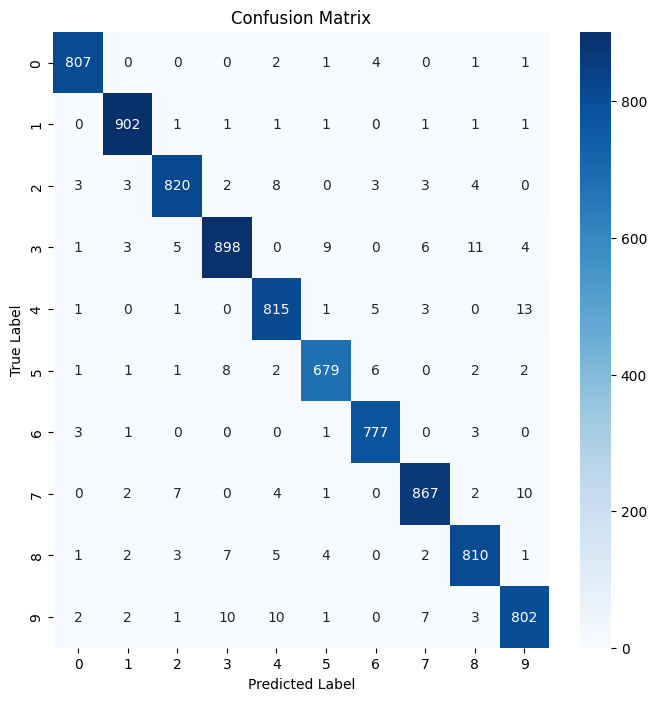

In [40]:
cm = confusion_matrix(y_val, y_preds_val)


plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_val), yticklabels=np.unique(y_val))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

1. High Accuracy on Diagonal:
* Most of the values are concentrated on the diagonal, which indicates that the model is accurately classifying the majority of the digits. For example, the model correctly classified 807 instances of digit '0', 902 instances of digit '1', and so on.

2. Common Misclassifications:
* The matrix shows where the model tends to confuse one digit with another:
 * Digit '5' was misclassified as '3' in 8 cases and as '6' in 6 cases.
 * Digit '8' was misclassified as '3' in 7 cases and as '5' in 4 cases.
 * Digit '9' was misclassified as '7' in 7 cases and as '4' in 13 cases.
 * These off-diagonal elements highlight the digits that the model finds more challenging to distinguish.

3. Model Strengths and Weaknesses:
* Strengths: The model performs very well on certain digits, such as '1', '7', and '0', where the majority of predictions are accurate.
* Weaknesses: There are noticeable misclassifications between certain pairs of digits, especially those that have similar shapes (like '3' and '5', '8' and '3', or '4' and '9').

## Train model to predict on test data

To gain as much information from data to be able to infrence well. New SVC model is trained using whole dataset and baseline paremeters


In [41]:
# model = SVC(**base_params)
# model.fit(X,y)

In [42]:
# test = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")
# test = test/255 # Normalization 
# test_numpy = test.to_numpy()

In [43]:
# test_numpy

In [44]:
# final_predictions = model.predict(test_numpy)

In [45]:
# submission = pd.DataFrame({
#     "ImageId": list(range(1, len(final_predictions) + 1)),
#     "Label": final_predictions
# })

# submission.to_csv('submission.csv', index=False)
# submission

# Shallow learning algorythms (SVC) summary
1. Data Information
- The dataset was a balanced one with no missing data.
- The dataset consisted of images represented in a DataFrame format, with 785 columns (1 label and 784 pixels) per image.

2. Data Preprocessing
- The dataset was in DataFrame format, which is not ideal for processing images. I converted it into a NumPy array. The next step was normalization to scale pixel values from 0-255 to 0-1, which is crucial when working with models like SVC to ensure the features are on the same scale.
- Train and validation sets were used to evaluate the model's performance.

3. Modeling
- Initially, I checked a few reasonable models (Logistic Regression, Random Forest, KNN, SGD, SVC) for this particular task. They were trained using cross-validation to get more robust and fair results.
- Next, the model with the best performance was chosen — SVC.
- RandomizedSearchCV and GridSearchCV were used to fine-tune hyperparameters, but it turned out that the baseline model was the best choice, and hyperparameter tuning did not improve performance.
- To better understand the model's performance and compare the baseline model to the GridSearchCV model, I trained the baseline model again and validated it using the same dataset that the GridSearchCV model was validated on. It turned out that the model after GridSearchCV achieved better accuracy than the baseline model, but the difference was minimal. In the end, the baseline model was chosen due to its consistent performance across all metrics in the training set.

4. Baseline model evaluation
- Baseline model was evaluated using a confusion matrix, which showed that the model performed well across most digits, with few misclassifications. This, along with the strong performance metrics on the validation set, suggests the model has a good ability to generalize

5. Results
- The final SVC model, trained on the whole normalized dataset, achieved **0.97521** accuracy.

**ISSUE**
It is important to note that, while working with this dataset, I encountered a problem: the accuracy on the training set was **lower** than on the validation set.




# PyTorch Part
In this part of the notebook I am going to learn the basics of PyTorch as well as compare simple neural network performance with shallow lerarning algortyhm like SVC

In [46]:
pip install torchmetrics


Note: you may need to restart the kernel to use updated packages.


In [47]:
#  Tools 
import torch
import torch.nn as nn 
import torch.optim as optim
import torchvision
from torch.utils.data import TensorDataset, DataLoader

from torchmetrics import Accuracy, F1Score, Precision, Recall


In [48]:
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.2, random_state=42)

In [49]:
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).long()

In [50]:
X_val_tensor = torch.from_numpy(X_val).float()
y_val_tensor = torch.from_numpy(y_val).long()

In [51]:
# (batch_size, channels, height, width) that input is expected in PyTorch (Flattening)
X_train_tensor = X_train_tensor.view(-1,1,28,28)
X_val_tensor = X_val_tensor.view(-1,1,28,28)

In [52]:
X_train_tensor.shape, y_train_tensor.shape

(torch.Size([33600, 1, 28, 28]), torch.Size([33600]))

In [53]:
X_val_tensor.shape, y_val_tensor.shape


(torch.Size([8400, 1, 28, 28]), torch.Size([8400]))

In [54]:
# Create TensorDataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

In [55]:
# DataLoader
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

## Baseline Model
Baseline model is a simple Linear model, consisted of 2 Linear layers

In [56]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [57]:
# Setup metrics , sets average=macro to gain better info abut each class performance
accuracy = Accuracy(task="MULTICLASS", num_classes=10).to(device)
f1_score = F1Score(task="MULTICLASS", num_classes=10, average='macro').to(device)
precision = Precision(task="MULTICLASS", num_classes=10, average='macro').to(device)
recall = Recall(task="MULTICLASS", num_classes=10, average='macro').to(device)

# By adding  average='macro' we resolve the issue of the same values throught metrics bug : https://github.com/Lightning-AI/torchmetrics/issues/2280
# Epoch: 0 Train loss: 0.57457, Accuracy: 0.8466, F1: 0.8466, Precision: 0.8466, Recall: 0.8466
# Epoch: 10 Train loss: 0.49481, Accuracy: 0.8949, F1: 0.8949, Precision: 0.8949, Recall: 0.8949
# Epoch: 20 Train loss: 0.49902, Accuracy: 0.9002, F1: 0.9002, Precision: 0.9002, Recall: 0.9002
# Epoch: 30 Train loss: 0.51367, Accuracy: 0.8986, F1: 0.8986, Precision: 0.8986, Recall: 0.8986
# Epoch: 40 Train loss: 0.49867, Accuracy: 0.9036, F1: 0.9036, Precision: 0.9036, Recall: 0.9036
# Epoch: 49 Train loss: 0.50875, Accuracy: 0.9032, F1: 0.9032, Precision: 0.9032, Recall: 0.9032

In [58]:
# Create model
class base_linear_model(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape,out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )
        
    def forward(self, x):
        return self.layer_stack(x)

In [59]:
# initialize model
torch.manual_seed(42)

base_model = base_linear_model(
    input_shape=784,   # 28*28
    hidden_units=128,
    output_shape=10   # 10 numbers, from 0 to 9 
)

base_model.to(device)

base_linear_model(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [60]:
# Lossfunction and optim
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=base_model.parameters(), lr=0.01)

In [61]:
# Train  loop
epochs = 50

for epoch in range(epochs):
    
    train_loss =0
    accuracy.reset()
    f1_score.reset()
    precision.reset()
    recall.reset()
    
    base_model.train()
    for X, y in train_loader:
        
        X, y = X.to(device), y.to(device)
        
        y_preds = base_model(X)
        
        loss = loss_function(y_preds, y)

        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        predicted_class = y_preds.argmax(dim=1) # dim = 1 so we are looking for the highest value in 1 sample (image) NOT the highest value in one batch
        
        train_loss += loss.item()
        accuracy.update(predicted_class, y)
        f1_score.update(predicted_class, y)
        precision.update(predicted_class, y)
        recall.update(predicted_class, y)
            

    train_loss /= len(train_loader)
    train_acc = accuracy.compute().item()
    train_f1 = f1_score.compute().item()
    train_precision = precision.compute().item()
    train_recall = recall.compute().item()
    
    if epoch % 10 == 0 or epoch == epochs - 1:
        print(f"Epoch: {epoch} "
              f"Train loss: {train_loss:.5f}, "
              f"Accuracy: {train_acc:.4f}, "
              f"F1: {train_f1:.4f}, "
              f"Precision: {train_precision:.4f}, "
              f"Recall: {train_recall:.4f}")


Epoch: 0 Train loss: 0.57457, Accuracy: 0.8466, F1: 0.8443, Precision: 0.8444, Recall: 0.8445
Epoch: 10 Train loss: 0.49754, Accuracy: 0.8945, F1: 0.8931, Precision: 0.8931, Recall: 0.8931
Epoch: 20 Train loss: 0.49984, Accuracy: 0.8983, F1: 0.8969, Precision: 0.8969, Recall: 0.8969
Epoch: 30 Train loss: 0.48786, Accuracy: 0.9026, F1: 0.9014, Precision: 0.9014, Recall: 0.9014
Epoch: 40 Train loss: 0.49493, Accuracy: 0.9028, F1: 0.9015, Precision: 0.9015, Recall: 0.9015
Epoch: 49 Train loss: 0.51509, Accuracy: 0.9027, F1: 0.9015, Precision: 0.9015, Recall: 0.9015


In [62]:
def evaluate_model(model, data_loader, loss_function):
    """Function will evalute model's performance agains validation set and return dictionary of results 
    model : is PyTroch trained model
    data_loader: data loader with validation set
    loss_function: Choosen loos function"""
    
    val_loss=0
    accuracy.reset()
    f1_score.reset()
    precision.reset()
    recall.reset()
    
    model.eval()
    with torch.inference_mode():
        for X_val, y_val in data_loader:
            
            X_val, y_val = X_val.to(device), y_val.to(device)
            
            predictions = model(X_val)
            
            loss = loss_function(predictions, y_val)
            val_loss+=loss.item()
            
            predicted_class = predictions.argmax(dim=1)
            
            accuracy.update(predicted_class, y_val)
            f1_score.update(predicted_class, y_val)
            precision.update(predicted_class, y_val)
            recall.update(predicted_class, y_val)
            
            
    val_loss /= len(data_loader)
    val_acc = accuracy.compute().item()
    val_f1 = f1_score.compute().item()
    val_precision = precision.compute().item()
    val_recall = recall.compute().item()
    
    results = {
        "Loss" : val_loss,
        "Accuracy" : val_acc,
        "F1": val_f1,
        "Precision" : val_precision, 
        "Recall": val_recall
    }
    
    return results
            
    
    

In [63]:
base_line_results = evaluate_model(base_model,val_loader,loss_function)


In [64]:
base_line_results_df = pd.DataFrame(base_line_results, index=["Base Model"]).T
base_line_results_df

,Base Model
Loss,0.779130
Accuracy,0.877976
F1,0.876618
Precision,0.880218
Recall,0.877368


## Non-linear model

In [65]:
class non_linear_model(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.layer_stack=nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
        )
        
    def forward(self,x):
        return self.layer_stack(x)

In [66]:
torch.manual_seed(42)

n_model = non_linear_model(
    input_shape = 784,
    hidden_units = 128,
    output_shape = 10
)

n_model.to(device)

non_linear_model(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [67]:
# Lossfunction and optim
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=n_model.parameters(), lr=0.01)

In [68]:

for epoch in range(epochs):
    train_loss = 0
    train_acc = 0
    train_f1 = 0
    train_precision = 0
    train_recall = 0
    
    for X_train, y_train in train_loader:
        n_model.train()
        X_train, y_train = X_train.to(device), y_train.to(device)
        predictions = n_model(X_train)
        
        loss = loss_function(predictions, y_train)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        predicted_class = predictions.argmax(dim=1)
        
        train_loss += loss.item()
        train_acc += accuracy(predicted_class,y_train).item() # convert accuracy from tensor to numer so it can be added up
        train_f1 += f1_score(predicted_class, y_train).item()
        train_precision += precision(predicted_class, y_train).item()
        train_recall += recall(predicted_class, y_train).item()
        
    train_loss /= len(train_loader)
    train_acc /= len(train_loader)
    train_f1 /= len(train_loader)
    train_precision /= len(train_loader) 
    train_recall /= len(train_loader)
    
    if epoch % 10 == 0 or epoch == epochs - 1:
        print(f"Epoch: {epoch} "
              f"Train loss: {train_loss:.5f}, "
              f"Accuracy: {train_acc:.4f}, "
              f"F1: {train_f1:.4f}, "
              f"Precision: {train_precision:.4f}, "
              f"Recall: {train_recall:.4f}")
    

Epoch: 0 Train loss: 0.27331, Accuracy: 0.9164, F1: 0.8951, Precision: 0.9082, Recall: 0.9077
Epoch: 10 Train loss: 0.07620, Accuracy: 0.9810, F1: 0.9749, Precision: 0.9783, Recall: 0.9782
Epoch: 20 Train loss: 0.06871, Accuracy: 0.9861, F1: 0.9824, Precision: 0.9848, Recall: 0.9844
Epoch: 30 Train loss: 0.04827, Accuracy: 0.9906, F1: 0.9878, Precision: 0.9895, Recall: 0.9893
Epoch: 40 Train loss: 0.05993, Accuracy: 0.9919, F1: 0.9897, Precision: 0.9911, Recall: 0.9910
Epoch: 49 Train loss: 0.04244, Accuracy: 0.9943, F1: 0.9922, Precision: 0.9932, Recall: 0.9934


In [69]:
non_linear_model_results = evaluate_model(n_model,val_loader,loss_function)

In [70]:
non_linear_model_results_df = pd.DataFrame(non_linear_model_results, index=["Non-Linear model"]).T
non_linear_model_results_df

,Non-Linear model
Loss,0.966047
Accuracy,0.964881
F1,0.964869
Precision,0.965182
Recall,0.964742


In [71]:
results = non_linear_model_results_df.join(base_line_results_df)
results.style.highlight_max(axis=1, color="pink")

,Non-Linear model,Base Model
Loss,0.966047,0.779130
Accuracy,0.964881,0.877976
F1,0.964869,0.876618
Precision,0.965182,0.880218
Recall,0.964742,0.877368


## Linear vs Not Linear model
Based on above metrics in evaluation data set,we can clearly see that Non-liniarity gave the model better chance to "understand" the data

## Issue
The model has high accuracy and hight loss on validation set. That is a problem.
It is still predictcs corectlly most of examples **BUT** because of high loss it is not sure of its predictions. 
That indicates that the model might Overfit or there is a call inbalace in data (whitch we already know it is not the case)


## Train Non-Linear model on whole dataset
Just as i did with shallow learning algorythm SVC, to be able to compare the results to that model and get better results i have to train model on whole X and y data set

In [78]:
train_data = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
y = train_data["label"].to_numpy()
X = train_data.drop("label", axis=1).to_numpy()
X = X/255.0 # Normalization

In [81]:
X.shape

(42000, 784)

In [82]:
y.shape

(42000,)

In [83]:
X_tensor = torch.from_numpy(X).float()
y_tensor = torch.from_numpy(y).long()

In [84]:
X.shape

(42000, 784)

In [85]:
X_tensor = X_tensor.view(-1,1,28,28)

In [86]:
# Dataset
whole_data_set = TensorDataset(X_tensor,y_tensor)

In [87]:
# DataLoader
whole_loader = DataLoader(whole_data_set,batch_size=32,shuffle=True)

In [88]:
class final_model(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.layer_stack=nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
        )
        
    def forward(self, x):
        return self.layer_stack(x)

In [89]:
torch.manual_seed(42)

final_model = final_model(
    input_shape = 784,
    hidden_units = 128,
    output_shape = 10
)

final_model.to(device)

final_model(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [90]:
# Lossfunction and optim
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=final_model.parameters(), lr=0.01)

In [91]:
# Train  loop
epochs = 50

for epoch in range(epochs):
    
    loss_ =0
    accuracy.reset()
    f1_score.reset()
    precision.reset()
    recall.reset()
    
    final_model.train()
    for X, y in whole_loader:
        
        X, y = X.to(device), y.to(device)
        
        y_preds = final_model(X)
        
        loss = loss_function(y_preds, y)

        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        predicted_class = y_preds.argmax(dim=1) 
        
        loss_ += loss.item()
        accuracy.update(predicted_class, y)
        f1_score.update(predicted_class, y)
        precision.update(predicted_class, y)
        recall.update(predicted_class, y)
            

    loss_ /= len(whole_loader)
    train_acc = accuracy.compute().item()
    train_f1 = f1_score.compute().item()
    train_precision = precision.compute().item()
    train_recall = recall.compute().item()
    
    if epoch % 10 == 0 or epoch == epochs - 1:
        print(f"Epoch: {epoch} "
              f"Loss: {loss_:.5f}, "
              f"Accuracy: {train_acc:.4f}, "
              f"F1: {train_f1:.4f}, "
              f"Precision: {train_precision:.4f}, "
              f"Recall: {train_recall:.4f}")

Epoch: 0 Loss: 0.25562, Accuracy: 0.9242, F1: 0.9235, Precision: 0.9236, Recall: 0.9234
Epoch: 10 Loss: 0.09230, Accuracy: 0.9783, F1: 0.9781, Precision: 0.9781, Recall: 0.9781
Epoch: 20 Loss: 0.07549, Accuracy: 0.9873, F1: 0.9872, Precision: 0.9872, Recall: 0.9872
Epoch: 30 Loss: 0.06369, Accuracy: 0.9897, F1: 0.9896, Precision: 0.9897, Recall: 0.9896
Epoch: 40 Loss: 0.05778, Accuracy: 0.9924, F1: 0.9924, Precision: 0.9924, Recall: 0.9924
Epoch: 49 Loss: 0.04892, Accuracy: 0.9938, F1: 0.9937, Precision: 0.9937, Recall: 0.9937


## Predictions with Non-linear model

In [92]:
test = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")
test = test/255 # Normalization 
test_numpy = test.to_numpy()

In [93]:
test_tensor = torch.from_numpy(test_numpy).float()
test_tensor = test_tensor.view(-1,1,28,28)
test_tensor.shape

torch.Size([28000, 1, 28, 28])

In [98]:
test_loader = DataLoader(test_tensor, batch_size=batch_size, shuffle=False)


In [99]:
final_model.eval()

predictions = []

with torch.inference_mode():
    for data in test_loader:
        data = data.to(device)
        
        preds = final_model(data)
        
        predicted_class = preds.argmax(dim=1)
        
        predictions.extend(predicted_class.cpu().numpy())
        
predictions = np.array(predictions)

        
        
        
        

In [100]:
predictions[:10]

array([2, 0, 9, 9, 3, 7, 0, 3, 0, 3])

## PyTorch model submission


In [101]:
submission = pd.DataFrame({
    "ImageId": list(range(1, len(predictions) + 1)),
    "Label": predictions
})

submission.to_csv('submission.csv', index=False)
submission

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9


That model has scored 0.96839


# SUMMARY
This notebook cosist of two approaches that tries to sole MNIST problem:
- Shallow learning algortyhms 
- Simple neural network

In both cases data preprocessing looked the same - from DataFrame to Numpy and apply normalization (in case of PyTorch also transformation to tensor) 

The best shallow learning algortym was SVC and after hyperparameter tuning it scored : 0.97521 on test data. But it also has some problems:
- the accuracy on the training set was **lower** than on the validation set whitch is quite confusing to me

PyTorch approach consisted of building simple Linear model whitch was not great in terms of metrtics and then building second model this time adding non-linearity. That approach turned out to gave better results, but again not without some issues: 
- in both linear and non-linear model while metrics like accuray, f1_score , recall and preciosn was high also loss was **high** which indicated that model was not sure of its predictions.
In further work with MNIST problem that issue can not stay unaddresed. Hyperparameters of NN shoud be tuned, experimentation done like: 
- adding regularization
- use of dropout
- adjusting learning rate and batch size

Finally better to that task suited SVC model, **BUT** we can not forget that this model was tuned and NN was not! Also NN was trained using just 50 epochs (for speed sake). It is highly likely that when NN would be tuned, and experimented with the results would be better. 

## Small Request
If you saw any mistake in my code or logic, or you want to give me some advice do not hasitate and please comment. I am a begginer and want to learn more!